In [1]:
from keras.models import Model
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.layers.advanced_activations import *
from keras import metrics
from keras.applications import *
from keras.preprocessing import image
from keras.initializers import *
from keras import losses
from keras.preprocessing.image import load_img, save_img, img_to_array
import tensorflow as tf

import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cv2

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
CONTENT = 'input.jpg'
STYLE = 'test_content.jpeg'

dimension = 256

In [3]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(dimension, dimension))
    img = img_to_array(img)
#     img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

# util function to convert a tensor into a valid image
def deprocess_image(x):
#     x = x.reshape((dimension, dimension, 3))
    # Remove zero-center by mean pixel
    x = np.copy(x)
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

## From Keras documentations

In [5]:
content_img = preprocess_image(CONTENT)
style_img = preprocess_image(STYLE)

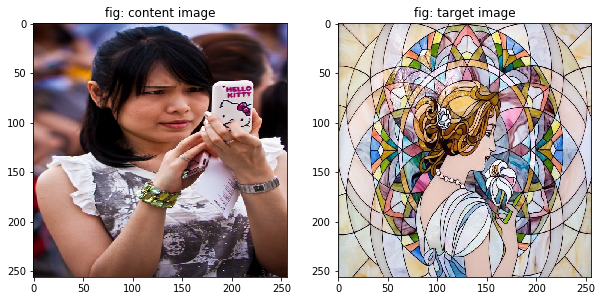

In [24]:
plt.figure(figsize = (10,10))
plt.subplot(1,2 , 1)
plt.title('fig: content image')
plt.imshow(deprocess_image(content_img))
plt.subplot(1,2 , 2)
plt.title('fig: target image')
plt.imshow(deprocess_image(style_img))
plt.show()

In [40]:
content_tensor = K.constant(content_img)
style_tensor = K.constant(style_img)
resultant_tensor = K.variable(content_img)

## Settinh up all the necessary tensors required

In [41]:
content_weight = 1
style_weight = 1e3
style_weights = [0.2,0.2,0.2,0.2,0.2]

content_layers = [
                    'block4_conv2',
                ]
style_layers = [
                    'block1_conv1',
                    'block2_conv1',
                    'block3_conv1',
                    'block4_conv1',
                    'block5_conv1',
                ]

In [42]:
vgg_model = VGG16( weights = 'imagenet' , include_top = False , input_shape = (dimension , dimension , 3))

In [43]:
vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

In [44]:
content_layer_tensors = [ vgg_model.get_layer(layer).output for layer in content_layers]
style_layer_tensors = [vgg_model.get_layer(layer).output for layer in style_layers]

In [45]:
vgg_feature = Model(inputs = vgg_model.input , outputs = content_layer_tensors + style_layer_tensors)

In [46]:
inputs = K.concatenate([K.expand_dims(resultant_tensor,axis = 0) , 
                        K.expand_dims(content_tensor , axis = 0) , 
                        K.expand_dims(style_tensor , axis = 0)] , axis = 0)
features = vgg_feature(inputs)

In [47]:
content_layers_len = len(content_layers)
style_layers_len = len(style_layers)

In [48]:
## Creating the content loss for the input
content_loss = 0
for i in range(content_layers_len):
    print(content_layers[i])
    loss = K.sum(K.square(features[i][0] - features[i][1])) / 2
    content_loss+= loss

block4_conv2


In [49]:
def get_gram_matrix(tensor):
    shape = K.int_shape(tensor)
    N = shape[2]
    M = shape[0]*shape[1]
    features = K.reshape(tensor , shape = (shape[0]*shape[1], shape[2]))
    return K.dot(K.transpose(features) , features ) / (2*N*M)


## Style loss
style_loss = 0
for i in range(content_layers_len , content_layers_len + style_layers_len):
    print(style_layers[i - content_layers_len])
    gram_result = get_gram_matrix(features[i][0]) ## (c , h*w) * (h*w , c)
    gram_style = get_gram_matrix(features[i][2]) ## 
    loss = style_weights[i - content_layers_len]  * K.sum((K.square(gram_result - gram_style)))
    style_loss += loss

block1_conv1
block2_conv1
block3_conv1
block4_conv1
block5_conv1


In [50]:
## total variation loss
def total_variation_loss(x):
    a = K.square(
        x[:dimension - 1, :dimension - 1, :] - x[ 1:, :dimension - 1, :])
    b = K.square(
        x[:dimension - 1, :dimension - 1, :] - x[ :dimension - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))
tv_loss = total_variation_loss(resultant_tensor)

In [51]:
total_loss = content_weight*content_loss + style_weight*style_loss + tv_loss

In [52]:
optim = Adam(lr = 1)
update = optim.get_updates(loss = total_loss, params = [resultant_tensor])
iterate = K.function([] ,[total_loss , content_loss,style_loss]
                     , updates = update )

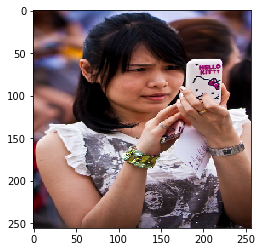

In [53]:
plt.imshow(deprocess_image(K.get_value(resultant_tensor)))

epoch: 0 total loss: 6979118400000.0 style loss: 6977174000.0 content loss: 0.0


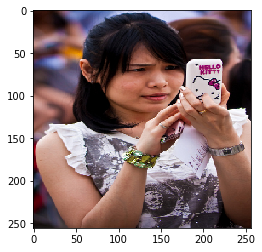

epoch: 100 total loss: 200895500000.0 style loss: 172431170.0 content loss: 21129521000.0
epoch: 200 total loss: 111253955000.0 style loss: 81166070.0 content loss: 22014624000.0
epoch: 300 total loss: 85627660000.0 style loss: 55158460.0 content loss: 22149837000.0
epoch: 400 total loss: 72996190000.0 style loss: 42461148.0 content loss: 22110740000.0
epoch: 500 total loss: 65375003000.0 style loss: 34972140.0 content loss: 21951697000.0


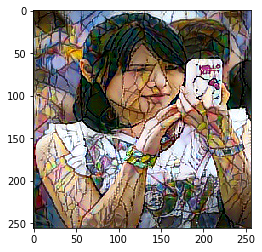

epoch: 600 total loss: 60253626000.0 style loss: 30058196.0 content loss: 21769134000.0
epoch: 700 total loss: 56519967000.0 style loss: 26570516.0 content loss: 21581070000.0
epoch: 800 total loss: 53632760000.0 style loss: 23942672.0 content loss: 21399998000.0
epoch: 900 total loss: 51280860000.0 style loss: 21857864.0 content loss: 21222520000.0
epoch: 1000 total loss: 49310286000.0 style loss: 20170078.0 content loss: 21035459000.0


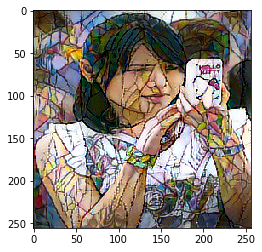

epoch: 1100 total loss: 47636144000.0 style loss: 18761738.0 content loss: 20867310000.0
epoch: 1200 total loss: 46190310000.0 style loss: 17570400.0 content loss: 20711342000.0
epoch: 1300 total loss: 44934400000.0 style loss: 16566007.0 content loss: 20556825000.0
epoch: 1400 total loss: 43832627000.0 style loss: 15695401.0 content loss: 20420061000.0
epoch: 1500 total loss: 42838580000.0 style loss: 14931159.0 content loss: 20280695000.0


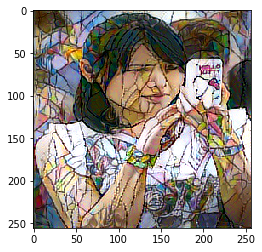

epoch: 1600 total loss: 41940718000.0 style loss: 14252159.0 content loss: 20149322000.0
epoch: 1700 total loss: 41133953000.0 style loss: 13649790.0 content loss: 20028232000.0
epoch: 1800 total loss: 40411116000.0 style loss: 13118371.0 content loss: 19916407000.0
epoch: 1900 total loss: 39757373000.0 style loss: 12651805.0 content loss: 19804488000.0
epoch: 2000 total loss: 39164290000.0 style loss: 12239688.0 content loss: 19696845000.0


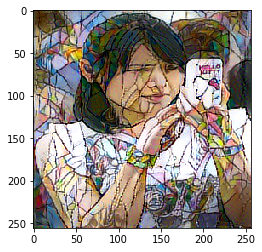

epoch: 2100 total loss: 38621070000.0 style loss: 11865709.0 content loss: 19598578000.0
epoch: 2200 total loss: 38126424000.0 style loss: 11530197.0 content loss: 19506220000.0
epoch: 2300 total loss: 37667336000.0 style loss: 11227271.0 content loss: 19411808000.0
epoch: 2400 total loss: 37237207000.0 style loss: 10936525.0 content loss: 19331121000.0
epoch: 2500 total loss: 36846236000.0 style loss: 10677317.0 content loss: 19255194000.0


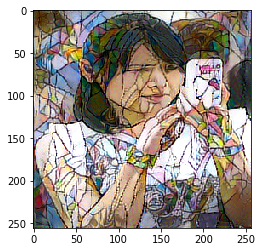

KeyboardInterrupt: 

In [54]:
epochs = 10000
for epoch in range(epochs):
    loss = iterate(inputs = [])
#     print(loss)
    if epoch % 100 == 0:
        print("epoch:",epoch ,"total loss:",loss[0],"style loss:",loss[2],"content loss:",loss[1])
    if epoch % 500 == 0:
        plt.imshow(deprocess_image(K.get_value(resultant_tensor)))
        plt.show()

In [ ]:
plt.imshow(deprocess_image(K.get_value(resultant_tensor)))